# Using Tensorflow for Assignment2
### 2016110648 李怡婷

In [21]:
import math
import timeit
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from time import time
from __future__ import division, print_function

## Same model with task1
### Input data
为了满足Tensor的的性质，这里把channels放在最前面的一步去掉了，得到的Tensor可以直接投入model

In [22]:
from dataset import load_cifar10

def get_cifar10_data(n_train=49000, n_val=1000, n_test=10000, subtract_mean=True):

    X_train, y_train, X_test, y_test = load_cifar10()

    # Subsample the data
    mask = list(range(n_train, n_train + n_val))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(n_train))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(n_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = get_cifar10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Model building
Tensor shape: N x H x W x C

N is the number of input data  
H is the height of the feature map  
W is the width of the feature map  
C is the number of channels in the feature map.

**Split dataset**

In [23]:
class Split(object):
    def __init__(self, x, y, batch_size, shuffle=True):
        self.x = x 
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __iter__(self):
        N = self.x.shape[0]
        B = self.batch_size
        idx = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idx)
        return iter((self.x[i:i+B], self.y[i:i+B]) for i in range(0, N, B))
    
train_dset = Split(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Split(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Split(X_test, y_test, batch_size=64)

In [24]:
class CNN(tf.keras.Model):
    def __init__(self, channel, hidden_units, num_classes):
        super().__init__()
        initializer = tf.variance_scaling_initializer(scale=0.01)
        self.conv = tf.layers.Conv2D(filters=channel, kernel_size=(7, 7), strides=(1, 1),padding='valid', activation=tf.nn.relu, use_bias=True)
        self.pool = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
        self.fc1 = tf.layers.Dense(hidden_units, activation=tf.nn.relu, kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes, kernel_initializer=initializer)
        
    def call(self, x, training=None):
        x = self.conv(x)
        x = self.pool(x)
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        scores = self.fc2(x)
        return scores

In [25]:
def train(model_init, optimizer_init, num_epochs=1,plot=True,GPUorNot=False):
    
    tf.reset_default_graph()
    
    if GPUorNot:
        device = '/device:GPU:0'
    else:
        device = '/cpu:0'
        
    with tf.device(device):
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        is_training = tf.placeholder(tf.bool, name='is_training')
        scores = model_init(x, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)
        
        optimizer = optimizer_init()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)
            
    fig_loss = np.zeros([766])
            
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                fig_loss[t] = loss_np
                
                num_correct, num_samples = 0, 0
                for x_batch, y_batch in val_dset:
                    feed_dict = {x: x_batch, is_training: 0}
                    scores_np = sess.run(scores, feed_dict=feed_dict)
                    y_pred = scores_np.argmax(axis=1)
                    num_samples += x_batch.shape[0]
                    num_correct += (y_pred == y_batch).sum()
                    acc = float(num_correct) / num_samples
                    
                if t % 100 == 0:
                    print('Iteration %d, loss = %.4f, accuracy = %.2f%%' % (t, loss_np, 100 * acc))
                t += 1
                
    if plot == True:       
        fig, ax = plt.subplots()
        lns = ax.plot(np.arange(t), fig_loss, label="Loss")
        ax.set_xlabel('iteration')
        ax.set_ylabel('training loss')
        plt.legend(lns,loc=7)
        plt.show()

Starting epoch 0
Iteration 0, loss = 2.3101, accuracy = 7.90%
Iteration 100, loss = 1.9048, accuracy = 32.40%
Iteration 200, loss = 1.8897, accuracy = 27.40%
Iteration 300, loss = 2.0112, accuracy = 29.10%
Iteration 400, loss = 2.1283, accuracy = 21.90%
Iteration 500, loss = 2.1875, accuracy = 25.70%
Iteration 600, loss = 2.1035, accuracy = 20.40%
Iteration 700, loss = 2.0621, accuracy = 23.90%


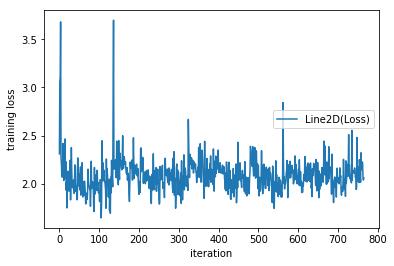

Time consuming: 560.941941s


In [86]:
learning_rate = 3e-3
channel, hidden_units, num_classes = 32, 1024, 10

def model_init(inputs, is_training):
    return CNN(channel, hidden_units, num_classes)(inputs)

def optimizer_init():
    return tf.train.GradientDescentOptimizer(learning_rate)

t0=time()
train(model_init, optimizer_init,plot=True, GPUorNot = False)
t1=time()
print('Time consuming: %fs' % (t1 - t0))

In [ ]:
learning_rate = 3e-3
channel, hidden_units, num_classes = 32, 1024, 10

def model_init(inputs, is_training):
    return CNN(channel, hidden_units, num_classes)(inputs)

def optimizer_init():
    return tf.train.GradientDescentOptimizer(learning_rate)

t0=time()
train(model_init, optimizer_init,plot=True, GPUorNot = True)
t1=time()
print('Time consuming: %fs' % (t1 - t0))

在集群上运行发现速度有极大提升

## Improve the model
add batch normalization  
change the the padding method of pooling and convolution layer  
change some parameters and weight initializers  

In [34]:
class CNN_improve(tf.keras.Model):
    def __init__(self, channel1, channel2, hidden_units, num_classes):
        super().__init__()
        initializer = tf.variance_scaling_initializer(scale=0.01)
        bias_initializer = tf.initializers.random_normal(0,0.1)
        self.conv1 = tf.layers.Conv2D(filters=channel1, kernel_size=(3, 3), strides=(1, 1),padding='same', activation=tf.nn.relu, use_bias=True)
        self.pool1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')
        self.norm1 = tf.layers.BatchNormalization()
        self.conv2 = tf.layers.Conv2D(filters=channel2, kernel_size=(3, 3), strides=(1, 1),padding='same', activation=tf.nn.relu, use_bias=True)
        self.pool2 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')
        self.norm2 = tf.layers.BatchNormalization()
        self.fc1 = tf.layers.Dense(hidden_units, activation=tf.nn.relu,use_bias= True, kernel_initializer=initializer,bias_initializer=bias_initializer)
        self.fc2 = tf.layers.Dense(num_classes, use_bias= True, kernel_initializer=initializer,bias_initializer=bias_initializer)
        
    def call(self, x, training=None):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.norm2(x)
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        scores = self.fc2(x)
        return scores

Starting epoch 0
Iteration 0, loss = 2.3155, accuracy = 9.00%
Iteration 100, loss = 1.5854, accuracy = 44.20%
Iteration 200, loss = 1.2872, accuracy = 47.00%
Iteration 300, loss = 1.6039, accuracy = 49.10%
Iteration 400, loss = 1.3360, accuracy = 53.50%
Iteration 500, loss = 1.4362, accuracy = 52.70%
Iteration 600, loss = 1.4651, accuracy = 54.60%
Iteration 700, loss = 1.3200, accuracy = 55.90%


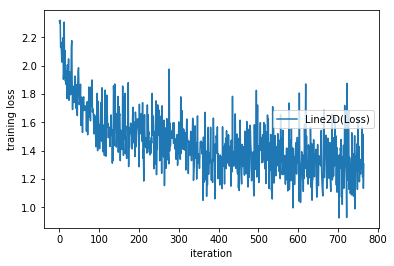

Time consuming: 563.430492s


In [90]:
learning_rate = 1e-3
channel1, channel2, hidden_units, num_classes = 32, 64, 1024, 10

def model_init(inputs, is_training):
    return CNN_improve(channel1, channel2, hidden_units, num_classes)(inputs)

def optimizer_init():
    return tf.train.GradientDescentOptimizer(learning_rate)

t0=time()
train(model_init, optimizer_init, plot=True, GPUorNot = False)
t1=time()
print('Time consuming: %fs' % (t1 - t0))

### More Optimizers
优化器参数和功能实现参考了这篇文章：https://blog.csdn.net/brucewong0516/article/details/78838124

**1. Adagrad**

AdaGrad可以自动变更学习速率,只是需要设定一个全局的学习速率ϵ,但是这并非是实际学习速率,实际的速率是与以往参数的模之和的开方成反比的.也许说起来有点绕口,不过用公式来表示就直白的多: 

ARGs:  
全局学习速率 ϵ, 初始参数 θ, 数值稳定量δ 
中间变量: 梯度累计量r(初始化为0)

Starting epoch 0
Iteration 0, loss = 2.3239, accuracy = 8.60%
Iteration 100, loss = 1.5812, accuracy = 44.40%
Iteration 200, loss = 1.2763, accuracy = 45.80%
Iteration 300, loss = 1.5699, accuracy = 47.00%
Iteration 400, loss = 1.3400, accuracy = 50.90%
Iteration 500, loss = 1.3922, accuracy = 52.00%
Iteration 600, loss = 1.3958, accuracy = 53.60%
Iteration 700, loss = 1.3250, accuracy = 54.30%


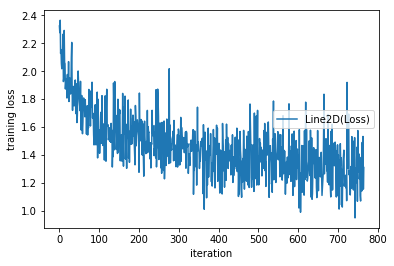

Time consuming: 577.307596s


In [91]:
channel1, channel2, hidden_units, num_classes = 32, 64, 1024, 10

def model_init(inputs, is_training):
    return CNN_improve(channel1, channel2, hidden_units, num_classes)(inputs)

def optimizer_init():
    return tf.train.AdagradOptimizer(learning_rate=1e-3,initial_accumulator_value=0.1,use_locking=False,name='Adagrad')

t0=time()
train(model_init, optimizer_init, plot=True, GPUorNot = False)
t1=time()
print('Time consuming: %fs' % (t1 - t0))

**2. RMSprop**

RMSProp通过引入一个衰减系数，让r每回合都衰减一定比例，类似于Momentum中的做法，是对AdaGrad算法的改进。

ARGs:  
全局学习速率 ϵ, 初始参数 θ, 数值稳定量δ，衰减速率ρ 
中间变量: 梯度累计量r(初始化为0)

Starting epoch 0
Iteration 0, loss = 2.3536, accuracy = 8.30%
Iteration 100, loss = 1.5533, accuracy = 43.50%
Iteration 200, loss = 1.2987, accuracy = 45.10%
Iteration 300, loss = 1.5336, accuracy = 48.10%
Iteration 400, loss = 1.4209, accuracy = 51.50%
Iteration 500, loss = 1.4217, accuracy = 53.00%
Iteration 600, loss = 1.4843, accuracy = 51.70%
Iteration 700, loss = 1.3864, accuracy = 52.70%


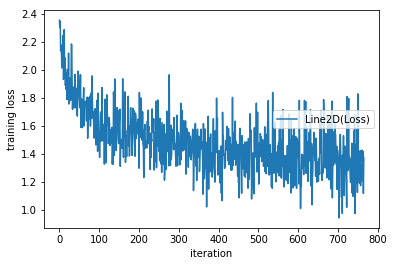

Time consuming: 573.671717s


In [92]:
channel1, channel2, hidden_units, num_classes = 32, 64, 1024, 10

def model_init(inputs, is_training):
    return CNN_improve(channel1, channel2, hidden_units, num_classes)(inputs)

def optimizer_init():
    return tf.train.RMSPropOptimizer(learning_rate=1e-3,decay=0.9,momentum=0.8,name='RMSProp')

t0=time()
train(model_init, optimizer_init, plot=True, GPUorNot = False)
t1=time()
print('Time consuming: %fs' % (t1 - t0))

 Discuss your observation:  
 1. 从时间的角度，Adagrad费时较长，rmsprop费时较短，但总体差不多
 2. 从convergence的角度，两者表现差不多
 3. 从accuracy的角度，Adagrad似乎的增长和总体表现更好